AI Programming - SW Lee

# Lab 08: Deep Q Learning Network (a.k.a DQN)
## Exercise: Cart Pole, Lunar Lander

### Prepare Library Packages

In [ ]:
# Check if this code runs in Colab
RunningInCOLAB = 'google.colab' in str(get_ipython()) # 코랩에서 실행하는지 여부를 확인하는 코드

if RunningInCOLAB: # 코랩에서 실행할 경우
    !pip install swig # swig 설치, swig는 C/C++ 프로그램을 파이썬에서 사용할 수 있도록 해주는 도구
    !pip install gymnasium # gymnasium 설치  # gymnasium은 OpenAI의 gym 환경을 확장한 것 
    !pip install gymnasium[box2d] # gymnasium의 box2d 환경 설치 # box2d는 2D 물리 시뮬레이션 엔진
    from tqdm.notebook import tqdm # tqdm 라이브러리 설치 및 노트북에서 진행바를 표시하기 위해 tqdm.notebook에서 tqdm을 가져옴
else:
    from tqdm import tqdm # 코랩이 아닌 경우에는 tqdm을 가져옴

In [ ]:
import os # os 라이브러리 가져오기, 운영체제와 상호작용하기 위한 라이브러리
os.environ["KERAS_BACKEND"] = "tensorflow" # 케라스 백엔드를 텐서플로우로 설정

import numpy as np # numpy 라이브러리 가져오기 # 수학 및 과학 연산을 위한 라이브러리
import tensorflow as tf # 텐서플로우 라이브러리 가져오기 # 딥러닝 라이브러리
import keras # 케라스 라이브러리
가져오기 # 딥러닝 라이브러리
import matplotlib.pyplot as plt # matplotlib 라이브러리 가져오기 # 시각화 라이브러리

import gymnasium as gym # gymnasium 라이브러리 가져오기 # OpenAI의 gym 환경을 확장한 것
from gymnasium import wrappers # gymnasium의 wrappers 가져오기 # 환경을 래핑하기 위한 라이브러리
 
from collections import deque # collections 라이브러리에서 deque 가져오기 # 양방향 큐
import random # random 라이브러리 가져오기 # 난수 생성을 위한 라이브러리

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU') # GPU 디바이스 목록 가져오기
print(physical_devices) # GPU 디바이스 목록 출력
try: # GPU가 감지되면
    tf.config.experimental.set_memory_growth(physical_devices[0], True) # 메모리 증가를 자동으로 설정
except: # GPU가 감지되지 않으면
    print('GPU is not detected.') # GPU가 감지되지 않았다고 출력

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
gym.__version__ # gymnasium 버전 출력

'1.0.0'

### Select Environment

**Cart Pole**<br>
https://gymnasium.farama.org/environments/classic_control/cart_pole/

**Lunar Lander**<br>
https://gymnasium.farama.org/environments/box2d/lunar_lander/

In [80]:
# select evironment
# Discrete Action Space:    0 for Cartpole, 1 for LunarLander

SELECT_ENV = 1

In [ ]:
if SELECT_ENV == 0: # Cartpole 환경 선택
    env_name, res_prefix = 'CartPole-v1', 'cart' # 환경 이름과 결과 접두사 설정
    max_episodes, max_ep_steps, goal_score = 400, 500, 450 # 최대 에피소드 수, 최대 에피소드 단계 수, 목표 점수 설정
    b_size, h_size = 128, 1000 # 배치 크기, 은닉층 크기 설정
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0 # 네트워크 유형, 상태 너비, 상태 높이, 상태 깊이 설정
    kwargs = {'render_mode':'rgb_array'} # 키워드 인수 설정
elif SELECT_ENV == 1: # LunarLander 환경 선택
    env_name, res_prefix = 'LunarLander-v3', 'lunD' # 환경 이름과 결과 접두사 설정
    max_episodes, max_ep_steps, goal_score = 400, 1000, 200 # 최대 에피소드 수, 최대 에피소드 단계 수, 목표 점수 설정
    b_size, h_size = 128, 10000 # 배치 크기, 은닉층 크기 설정
    network_type, state_width, state_height, state_depth = 'dense', 0, 0, 0 # 네트워크 유형, 상태 너비, 상태 높이, 상태 깊이 설정
    kwargs = {'continuous':False, 'render_mode':'rgb_array'} # 키워드 인수 설정
else: assert False, 'environment selection error' # 환경 선택 오류

def create_env(): # 환경 생성 함수
    env = gym.make(env_name, **kwargs) # 환경 생성
    return env # 환경 반환

In [ ]:
def env_reset(env): # 환경 초기화 함수
    observation = env.reset() # 환경 초기화
    state = observation[0] if type(observation)==tuple else observation # 상태 설정
    return state # 상태 반환

def env_step(env, action): # 환경 단계 함수
    observation = env.step(action) # 환경 단계
    state = observation[0] # 상태 설정
    reward = observation[1] # 보상 설정
    done = observation[2] or observation[3] if len(observation)>4 else observation[2] # 완료 설정
    return state, reward, done # 상태, 보상, 완료 반환

In [ ]:
env = create_env() # 환경 생성
state = env_reset(env) # 환경 초기화
state, reward, done = env_step(env, env.action_space.sample()) # 환경 단계

### Check and Show Environment Variables

In [ ]:
action_shape = env.action_space.shape # 행동 공간 모양 설정
action_space_type = type(env.action_space)  # 행동 공간 유형 설정

if action_space_type==gym.spaces.discrete.Discrete: # 행동 공간 유형이 이산형일 경우
    actn_space = 'DISCRETE' # 행동 공간 설정
    action_shape = (1,) # 행동 모양 설정
    action_dims = 1 # 행동 차원 설정
    action_range = env.action_space.n # 행동 범위 설정
    num_actions = action_range  # number of actions is action range for DISCRETE actions
    action_batch_shape = (None, action_range) # 행동 배치 모양 설정
elif action_space_type==gym.spaces.box.Box: # 행동 공간 유형이 상자일 경우
    actn_space = 'CONTINUOUS' # 행동 공간 설정
    action_dims = action_shape[0] # 행동 차원 설정
    actn_uppr_bound = env.action_space.high[0] # 행동 상한 설정
    actn_lowr_bound = env.action_space.low[0] # 행동 하한 설정
    action_range = (actn_uppr_bound - actn_lowr_bound) # x0.5 for tanh output # 행동 범위 설정
    action_batch_shape = tuple([None]+[x for x in action_shape]) # 행동 배치 모양 설정
    num_actions = action_dims   # number of actions is action dimension for CONTINUOUS actions # 연속적인 행동의 경우 행동 차원이 행동 수
else: assert False, 'other action space type are not supported' # 다른 행동 공간 유형은 지원되지 않음

observation_space_type = type(env.observation_space) # 관찰 공간 유형 설정
observation_shape = env.observation_space.shape # 관찰 공간 모양 설정

if observation_space_type==gym.spaces.discrete.Discrete: # 관찰 공간 유형이 이산형일 경우
    observation_shape = (1,) # 관찰 공간 모양 설정
    num_states = env.observation_space.n # number of states is observation space for DISCRETE observations
elif observation_space_type==gym.spaces.box.Box: # 관찰 공간 유형이 상자일 경우
    num_states = observation_shape[0] # number of states is observation shape for CONTINUOUS observations
else: print('observation space type error') # 관찰 공간 유형 오류

state_shape = observation_shape # 상태 모양 설정
state_batch_shape = tuple([None]+[x for x in observation_shape]) # 상태 배치 모양 설정

value_shape = (1,) # 가치 모양 설정
num_values = 1 # number of values is 1 for value function

In [ ]:
print('Action space ', action_space_type) # 행동 공간 유형 출력
print('Action shape ', action_shape) # 행동 모양 출력
print('Action dimensions ', action_dims) # 행동 차원 출력
print('Action range ', action_range) # 행동 범위 출력
if action_space_type==gym.spaces.box.Box: # 행동 공간 유형이 상자일 경우
    print('Max Value of Action ', actn_uppr_bound) # 행동 상한 출력
    print('Min Value of Action ', actn_lowr_bound) # 행동 하한 출력
else: pass # 그 외의 경우는 넘어감
print('Action batch shape ', action_batch_shape) # 행동 배치 모양 출력

print('Observation space ', observation_space_type) # 관찰 공간 유형 출력
print('Observation shape ', observation_shape) # 관찰 모양 출력
print('Size of State Space ', num_states) # 상태 공간 크기 출력
print('State shape ', state_shape) # 상태 모양 출력
print('State batch shape ', state_batch_shape) # 상태 배치 모양 출력

print('Vallue shape ', value_shape) # 가치 모양 출력
print('Value dimensions ', num_values) # 가치 차원 출력

Action space  <class 'gymnasium.spaces.discrete.Discrete'>
Action shape  (1,)
Action dimensions  1
Action range  4
Action batch shape  (None, 4)
Observation space  <class 'gymnasium.spaces.box.Box'>
Observation shape  (8,)
Size of State Space  8
State shape  (8,)
State batch shape  (None, 8)
Vallue shape  (1,)
Value dimensions  1


### Define and Initialize The Agent
### **Exercise:** Define Deep Q-network (TensorFlow)

A NN of three fully-connected layers is enough for classic control problems.<br>

**Parameters for layer definition are:**<br>
hiddens = (unit # for layer1, unit # for layer2),<br>
act_fn: activation function,<br>
out_fn: activation function for output layer, <br>
init_fn: kernel initialization function

In [ ]:
def DQNet(hiddens, act_fn, out_fn, init_fn):    # hiddends = (layer1 units, layer2 units)
    inputs = keras.Input(shape=state_shape)  # input layer

    ### START CODE HERE ###

    l1 = keras.layers.Dense(units=hiddens[0], activation=act_fn, kernel_initializer=init_fn)(inputs) # hidden layer 1
    l2 = keras.layers.Dense(units=hiddens[1], activation=act_fn, kernel_initializer=init_fn)(l1) # hidden layer 2
    outputs = keras.layers.Dense(units=num_actions, activation=out_fn, kernel_initializer='he_uniform')(l2) # output layer

    ###  END CODE HERE  ###

    model = keras.Model(inputs=inputs, outputs=outputs, name='q_net') # model
    return model # return model

def build_DQNet(): # DQNet 생성 함수
    model = DQNet(hiddens=(32,32), act_fn='relu', out_fn='linear', init_fn='he_uniform') # DQNet 생성
    return model # DQNet 반환

In [ ]:
test_model = build_DQNet() # DQNet 생성
test_model.summary() # DQNet 요약 출력
del test_model # test_model 삭제

Model: "q_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)          │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ (None, 32)                  │             288 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ (None, 32)                  │           1,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_32 (Dense)                     │ (None, 4)                   │             132 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,476 (5.77 KB)

 Trainable params: 1,476 (5.77 KB)

 Non-trainable params: 0 (0.00 B)

**Model Summary:**

```
┏--------------------------------------┳-----------------------------┳-----------------┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡--------------------------------------╇-----------------------------╇-----------------┩
│ input_layer (InputLayer)             │ (None, 4 or 8)              │               0 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense (Dense)                        │ (None, 32)                  │      160 or 288 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense_1 (Dense)                      │ (None, 32)                  │           1,056 │
├--------------------------------------┼-----------------------------┼-----------------┤
│ dense_2 (Dense)                      │ (None, 2 or 4)              │       66 or 132 │
└--------------------------------------┴-----------------------------┴-----------------┘
```

The policy function in the Agent_Net is just for getting a SINGLE sample, not for training. So you have to set `training=False` if necessary.
Since the network takes batch format (i.e., `[batch,data]`), the input state should be given as `[None,...]` and the output should be taken as `[0,...]`.

### **Exercise:** Define Policy Functions

In [ ]:
class Agent_Net: #  에이전트 네트워크 클래스
    def __init__(self): # 초기화 함수
        self.policy_q = build_DQNet()                       # build policy network
        self.target_q = build_DQNet()                       # build target network
        self.target_update()                                # copy weights from policy to target

    def policy(self, state, epsilon, exploring):            # e-greedy policy if exploring==True
        state_input = tf.convert_to_tensor(state[None,...], dtype=tf.float32)   # make the state network-ready

        ### START CODE HERE ###

        if exploring:                                       # if e-greedy policy
            if tf.random.uniform([]) > epsilon:             # exploit if random > epsilon
                action_q = self.policy_q(state_input, training=False)   # get Q-values for input state
                action = tf.argmax(action_q, axis=1)        # find the action with maximum Q value
            else:                                           # explore else
                action = tf.random.uniform([], minval=0, maxval=num_actions, dtype=tf.int32)  # random action
        else:                                               # else greedy policy (exploitation)
            action_q = self.policy_q(state_input, training=False)   # get Q-values for input state
            action = tf.argmax(action_q, axis=1)            # find the action with maximum Q value

        # Squeeze the action to remove any extra dimensions and convert to scalar integer
        action = tf.squeeze(action) # action을 스칼라 정수로 변환

        ###  END CODE HERE  ###

        return action.numpy() # return action

    def target_update(self): # target update 함수
        self.target_q.set_weights(self.policy_q.get_weights())  # copy weights from policy network to target network
        return # return

In [ ]:
def test_policy(exploring): # 정책 테스트 함수

    epsilon = 0.1 # epsilon 설정
    state_input = tf.random.uniform((1,3)) # 상태 입력 설정
    action_range = 7 # 행동 범위 설정

    def policy_q(x):    # pretending policy_q network
        x = tf.random.uniform((tf.shape(x)[0],action_range)) # random Q-values
        return x # return x

    ### START CODE HERE ###

    if exploring:                                           # if e-greedy policy
        if tf.random.uniform([]) > epsilon:                 # exploit if random > epsilon
            action_q = policy_q(state_input)                # get Q-values for input state
            action = tf.argmax(action_q, axis=1)            # find the action with maximum Q value
        else:                                               # explore else
            action = tf.random.uniform([], minval=0, maxval=action_range, dtype=tf.int32)  # random action
    else:                                                   # else greedy policy (exploitation)
        action_q = policy_q(state_input)                    # get Q-values for input state
        action = tf.argmax(action_q, axis=1)                # find the action with maximum Q value

    # Squeeze the action to remove any extra dimensions and convert to scalar integer
    action = tf.squeeze(action)

    ###  END CODE HERE  ###

    return action # return action

tf.random.set_seed(2)
for _ in range(10): print(test_policy(True).numpy(), ' ', end='') # 정책 테스트
for _ in range(10): print(test_policy(False).numpy(), ' ', end='') # 정책 테스트

5  0  6  5  1  3  1  4  5  0  3  1  6  0  1  2  0  3  6  4  

**Expected Outputs:**

```
5  0  6  5  1  3  1  4  5  0  3  1  6  0  1  2  0  3  6  4
```

### Define and Initialize Replay Memory

The replay memory (or replay buffer) is implemented with `deque`, which maintians the fixed number of elements by discarding the oldest element automatically.<br>
The inputs of the `put_experience` function are from environments and the outputs of the `get_batch` function are fed to the NN. Therefore the output types should be tensors.

In [ ]:
class ReplayMemory: # 리플레이 메모리 클래스
    def __init__(self, memory_size): # 초기화 함수
        self.experiences = deque(maxlen=memory_size)    # allocate replay memory
        self.num_episodes = 0                           # set number of episode to zero

    def put_experience(self, experience):               # put an experience into replay memory
        state, action, next_state, reward, not_done = experience # unpack experience
        self.experiences.append((state, action, next_state, reward, not_done)) # append experience
        return # return

    def get_batch(self, num_samples):                   # get a batch of randomly sampled experiences
        state_batch, next_state_batch, action_batch, reward_batch, not_done_batch = [], [], [], [], [] # 배치 초기화

        sample_batch = random.sample(self.experiences, num_samples) # replay memory에서 샘플링

        for sample in sample_batch: # 샘플링된 샘플에 대해
            state, action, next_state, reward, not_done = sample # 샘플 언패킹
            state_batch.append(state) # 상태 추가
            action_batch.append(action) # 행동 추가
            next_state_batch.append(next_state) # 다음 상태 추가
            reward_batch.append(reward) # 보상 추가
            not_done_batch.append(not_done) # 완료되지 않은 것 추가

        batch = (tf.convert_to_tensor(state_batch, dtype=tf.float32), # 배치 생성
                tf.convert_to_tensor(action_batch, dtype=tf.int32), # 배치 생성
                tf.convert_to_tensor(next_state_batch, dtype=tf.float32), # 배치 생성
                tf.convert_to_tensor(reward_batch, dtype=tf.float32), # 배치 생성
                tf.convert_to_tensor(not_done_batch, dtype=tf.float32)) # 배치 생성
        return batch # 배치 반환

### **Exercise:** Initialize the replay memory

A single experience consists of `(state, action, next_state, reward, not_done)`. Be careful with **`not_done`**.

In [ ]:
def init_memory(mem, env, agent, num_samples): # 메모리 초기화 함수
    state = env_reset(env)                          # initialize environment
    for _ in range(num_samples): # 샘플 수만큼 반복

        ### START CODE HERE ###

        action = agent.policy(state, epsilon=1.0, exploring=True)   # get an action with the policy
        next_state, reward, done = env_step(env, action)          # observe the environment reaction
        experience = (state, action, next_state, reward, 1.0 - float(done))   # pack observations into experience tuple
        mem.put_experience(experience)                           # put the experience to replay memory
        state = env_reset(env) if done else next_state          # set the next state (reset env if done)

        ###  END CODE HERE  ###

    return


In [ ]:
tf.random.set_seed(2) # 시드 설정
keras.utils.set_random_seed(2) # 랜덤 시드 설정
test_agent = Agent_Net() # 에이전트 네트워크 생성
test_mem = ReplayMemory(4) # 리플레이 메모리 생성
test_env = create_env() # 환경 생성 
test_state = test_env.reset(seed=3) # 환경 초기화
init_memory(test_mem, test_env, test_agent, 4) # 메모리 초기화

if SELECT_ENV==1: # LunarLander 환경인 경우
    print(test_mem.get_batch(4)[0][0][:4].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[1].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[2][0][:4].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[3].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[4].numpy()) # 배치 출력
else:
    print(test_mem.get_batch(4)[0][0][:4].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[1].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[2][0][:4].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[3].numpy()) # 배치 출력
    print(test_mem.get_batch(4)[4].numpy()) # 배치 출력

del test_agent, test_mem
test_env.close()

[-0.01505842  1.4191642  -0.76619244  0.17035668]
[1 0 1 0]
[-0.03796177  1.427054   -0.7755038   0.08992036]
[-1.0618883 -1.0290995 -1.9180926 -1.4797792]
[1. 1. 1. 1.]


**Expected Outputs:**

```
[-0.04072088  0.18846463 -0.00277539 -0.32736924]
[1 0 1 0]
[-0.02550636 -0.00617038 -0.02836518 -0.04544564]
[1. 1. 1. 1.]
[1. 1. 1. 1.]
```
or
```
[-0.01505842  1.4191642  -0.76619244  0.17035668]
[1 0 1 0]
[-0.03796177  1.427054   -0.7755038   0.08992036]
[-1.0618883 -1.0290995 -1.9180926 -1.4797792]
[1. 1. 1. 1.]
```

### Learning Procedures

DQN trains the Q-network to minimize the difference:

$$ \delta_t = (r_{t} + \gamma \max_{\hat{a}_{t+1}} Q_T(s_{t+1}, \hat{a}_{t+1}; \theta_T)) - Q_P(s_t, a_t; \theta_P) $$

where $Q_T$ is a target network and $Q_P$ policy network.

Then the loss function is

$$ L(\theta_P) = \delta_t^2 $$

### **Exercise:** Define ONE step of Training Loop and Evaluation Loop

The following test has same codes as the `dqn_train` function except the last line.

In [ ]:
def test_training(): # 훈련 테스트 함수
    state_b = tf.random.uniform((3,4)) # 상태 배치 설정
    action_b = tf.random.uniform((3,), minval=0, maxval=7, dtype=tf.int32) # 행동 배치 설정
    next_state_b = tf.random.uniform((3,4)) # 다음 상태 배치 설정
    reward_b = tf.random.uniform((3,)) # 보상 배치 설정
    not_done_b = tf.random.uniform((3,)) # 완료되지 않은 것 배치 설정
    gamma = tf.random.uniform((1,)) # 감마 설정
    action_range = 7 # 행동 범위 설정

    class test_agent: # 테스트 에이전트 클래스
        def __init__(self): # 초기화 함수
            pass # pass
        def policy_q(self, x): # 정책 Q 함수
            return tf.reduce_sum(x, axis=-1, keepdims=True) # x의 합을 계산
        def target_q(self, x): # 목표 Q 함수
            return tf.reduce_sum(x, axis=-1, keepdims=True) # x의 합을 계산

    agent = test_agent() # 테스트 에이전트 생성

    ### START CODE HERE ###

    # 현재 정책으로 Q 값을 계산
    curr_q = agent.policy_q(state_b)  # Shape: (3, 1)

    # 목표 정책으로 Q 값을 계산하고, 그 중 최대 Q 값을 찾음
    next_q = agent.target_q(next_state_b)  # Shape: (3, 1)
    max_next_q = tf.reduce_max(next_q, axis=1, keepdims=True)  # Shape: (3, 1)

    # 목표 보상 계산 (b, 1)
    target_reward = reward_b[:, tf.newaxis] + gamma * max_next_q * not_done_b[:, tf.newaxis]  # Shape: (3, 1)

    # 원-핫 인코딩으로 액션에 해당하는 위치만 필터링
    action_v = tf.one_hot(action_b, action_range)  # Shape: (3, 7)

    # 라벨 계산 (b, a)
    label_q = curr_q + action_v * (target_reward - curr_q)  # Shape: (3, 7)
    label_q = label_q.numpy() # 라벨 Q를 넘파이 배열로 변환

    return label_q # 라벨 Q 반환



In [ ]:
tf.random.set_seed(2) # 시드 설정

ans = np.array([[1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 1.1889474 , 0.40853113],
                [2.713482  , 2.713482  , 2.4351463 , 2.713482  , 2.713482  , 2.713482  , 2.713482  ],
                [3.3669732 , 1.4427134 , 3.3669732 , 3.3669732 , 3.3669732 , 3.3669732 , 3.3669732 ]])
res = test_training() # 훈련 테스트
print('Training lable test passed.') if np.allclose(res,ans) else print('Training lable test failed.') # 훈련 라벨 테스트

Training lable test passed.


In [ ]:
def dqn_train(agent, batch, config): # DQN 훈련 함수
    state_b, action_b, next_state_b, reward_b, not_done_b = batch # 배치 언패킹
    gamma = config.gamma # 감마 설정

    ### START CODE HERE ###

    # get action probability with current (think of WHY!!) policy (b,a)
    curr_q = agent.policy_q(state_b)  # Shape: (batch_size, num_actions)

    # get action probability with target policy (b,a),
    # and then find the max Q value with it (b,)
    next_q = agent.target_q(next_state_b)  # Shape: (batch_size, num_actions)
    max_next_q = tf.reduce_max(next_q, axis=1, keepdims=True)  # Shape: (batch_size,1)

    # calculate target reward (b,1)
    target_reward = reward_b[:, tf.newaxis] + gamma * max_next_q * not_done_b[:, tf.newaxis]  # Shape: (batch_size,1)

    # make one-hot actions (b,a) to filter out other actions
    action_v = tf.one_hot(action_b, num_actions)  # Shape: (batch_size, num_actions)

    # make ground true labels for training (b,a)
    label_q = curr_q + action_v * (target_reward - curr_q)  # Shape: (batch_size, num_actions)

    # training with model.fit()
    logs = agent.policy_q.fit(state_b, label_q, verbose=0)

    ###  END CODE HERE  ###

    loss = logs.history['loss'][-1] # 손실 설정
    return loss # 손실 반환


In [ ]:
def evaluate_policy(env, agent, num_avg): # 정책 평가 함수

    total_reward = 0.0 # 총 보상 초기화
    episodes_to_play = num_avg # 평균을 내기 위한 에피소드 수 설정
    for i in range(episodes_to_play): # Play n episode and take the average
        state = env_reset(env) # 환경 초기화
        done = False # 완료 여부 초기화
        episode_reward = 0.0 # 에피소드 보상 초기화
        while not done: # 완료되지 않은 동안

            ### START CODE HERE ###

            action = agent.policy(state, epsilon=0.0, exploring=False)   # get an action with policy
            next_state, reward, done = env_step(env, action)            # take action and observe outcomes

            ###  END CODE HERE  ###

            state = next_state # 상태 업데이트
            episode_reward += reward # 에피소드 보상 업데이트
        total_reward += episode_reward # 총 보상 업데이트
    average_reward = total_reward / episodes_to_play # 평균 보상 계산

    return average_reward # 평균 보상 반환


### Define Epsilon Function

This is an example of exponential decay epsilon function. One of easist epsilon decay functions is simply to multiply 0.9. You can define your own epsilon function.

In [ ]:
# Exploration parameters for epsilon greedy strategy
class Epsilon:
    def __init__(self, max_episodes, decay_speed=1.0):
        self.explore_start = 1.0            # exploration probability at start
        self.explore_stop = 0.01            # minimum exploration probability
        self.decay_rate = decay_speed/max_episodes  # exp decay rate for exploration prob (10/max ≈ 0.99)
        self.episode_cnt = 0 # episode count

    def get_epsilon(self): # epsilon 가져오기 함수
        eps = (self.explore_stop # epsilon 설정
            + (self.explore_start - self.explore_stop) * tf.math.exp(-self.decay_rate * self.episode_cnt)) # epsilon 설정
        self.episode_cnt += 1 # 에피소드 카운트 업데이트
        return eps # epsilon 반환

### Define and Initialize Hyperparameters


In [ ]:
class configuration: # 구성 클래스
    def __init__(self):
        self.gamma = 0.99   # discount rate
        self.lr = 2e-4      # learning rate

config = configuration() # 구성 설정

In [ ]:
max_steps = max_episodes * max_ep_steps # 최대 단계 설정
batch_size = b_size # 배치 크기 설정
memory_size = h_size # 메모리 크기 설정

agent = Agent_Net() # 에이전트 네트 생성

memD = ReplayMemory(memory_size) # 리플레이 메모리 생성
init_memory(memD, env, agent, memory_size) # 메모리 초기화
epsF = Epsilon(max_episodes, 10.0) # 엡실론 생성
opt = tf.optimizers.Adam(learning_rate=config.lr, clipvalue=2.0) # 옵티마이저 생성

agent.policy_q.compile(optimizer=opt, loss='mse', jit_compile=False) # 정책 Q 컴파일

### Define Main Training Loop


### **Exercise:** Complete Main Training Loop

In [ ]:
logs = keras.callbacks.History() # 로그 생성
logs.history.update({'pi_loss':[]}) # 로그 업데이트
logs.history.update({'ereward':[]}) # 로그 업데이트
logs.history.update({'e-steps':[]}) # 로그 업데이트
logs.history.update({'vreward':[]}) # 로그 업데이트

# variables for simulation 
num_episodes = 0 # number of episodes simulated
val_episodes = 2            # exit condition

# variables for episode logging
pi_loss = 0.0 # policy loss

loss_sum = 0.0 # loss sum
epis_steps = 0 # episode steps
epis_reward = 0.0 # episode reward
eval_reward = -float('inf') # evaluation reward

# initialize training variables
epsilon = 1.0 # exploration probability
next_state = None # next state
done = True # done flag

pbar = tqdm(range(max_steps), bar_format='{l_bar}{bar:10}{r_bar}{bar:-10b}') # 진행바 생성

for sim_steps in pbar: # 시뮬레이션 단계 반복

    ### START CODE HERE ###

    state = env_reset(env) if done else next_state                          # 현재 상태 가져오기
    action = int(agent.policy(state, epsilon, exploring=True))              # e-그리디 정책에 따라 액션 선택 및 정수로 변환
    next_state, reward, done = env_step(env, action)                       # 액션 수행 및 결과 관찰

    experience = (state, action, next_state, reward, 1.0 - float(done))    # 새로운 경험 패킹
    memD.put_experience(experience)                                       # 경험을 리플레이 메모리에 저장

    batch = memD.get_batch(batch_size)                                    # 배치 가져오기
    step_pi_loss = dqn_train(agent, batch, config)                       # DQN 훈련


    ###  END CODE HERE  ###

    loss_sum += step_pi_loss                                # accumulate policy loss for a step
    epis_reward += reward                                   # accumulate reward for a step
    epis_steps += 1                                         # increase the number of steps for an episode

    # episode termination conditions
    if epis_steps>max_ep_steps: done = True

    # summarize episode
    if done:
        agent.target_update()                               # update target network whenever episode ends
        memD.num_episodes += 1                              # increase number of episode simulated
        epsilon = epsF.get_epsilon()                        # update decay epsilon value

        pi_loss = loss_sum / epis_steps                     # average policy loss for an episode

        pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps, 'evaluating':val_episodes})
        eval_reward = evaluate_policy(env, agent, 1)        # evaluate policy one time

        logs.history['pi_loss'].extend([pi_loss]) # 로그 업데이트
        logs.history['ereward'].extend([epis_reward]) # 로그 업데이트
        logs.history['e-steps'].extend([epis_steps]) # 로그 업데이트
        logs.history['vreward'].extend([eval_reward]) # 로그 업데이트

        loss_sum = 0.0 # 손실 합 초기화 
        epis_reward = 0.0 # 에피소드 보상 초기화
        epis_steps = 0 # 에피소드 단계 초기화
        num_episodes += 1 # 에피소드 수 증가

    else: pass

    pbar.set_postfix({'episode':num_episodes, 'loss':step_pi_loss, 'reward':eval_reward, 'steps':epis_steps}) # 진행바 업데이트

    # coditions to stop simulation
    if eval_reward > goal_score: # 목표 점수보다 높은 경우
        eval_reward = evaluate_policy(env, agent, val_episodes) # evaluate policy multiple times
    if eval_reward > goal_score: break # 목표 점수보다 높은 경우 종료
    if num_episodes > max_episodes: break # 최대 에피소드보다 많은 경우 종료

print('episodes:{0:5d}, loss:{1:7.5f}, val_reward {2:4.2f}'.format(num_episodes, pi_loss, eval_reward)) # 에피소드, 손실, 검증 보상 출력
print('total steps:', sim_steps+1) # 총 단계 출력


  0%|          | 0/400000 [00:00<?, ?it/s]

episodes:  122, loss:3.19056, val_reward 214.16
total steps: 73266


### Plot Training Histories

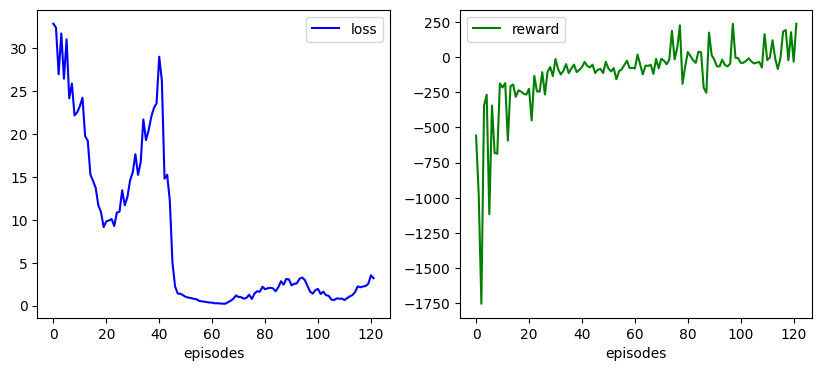

In [ ]:
# plot loss and accuracy
def plot_graphs(log_history, log_labels, graph_labels, graph_colors=['b-','g-']): # 그래프 플롯 함수
    num_graphs = len(log_labels) # 그래프 수 설정
    plt.figure(figsize=(5*num_graphs,4)) # 그래프 크기 설정
    for i in range(num_graphs): # 그래프 수만큼 반복
        plt.subplot(1,num_graphs,i+1) # 서브플롯 설정
        plt.plot(log_history[log_labels[i]], graph_colors[i], label=graph_labels[i]) # 그래프 플롯
        plt.xlabel('episodes') # x축 레이블 설정
        plt.legend() # 범례 설정
    plt.show() # 그래프 생성
    return # return

log_labels    = ['pi_loss', 'vreward'] # 로그 레이블 설정
label_strings = ['loss', 'reward'] # 레이블 문자열 설정
label_colors  = ['b-', 'g-'] # 레이블 색상 설정
plot_graphs(logs.history, log_labels, label_strings, label_colors) # 그래프 플롯

### Evaluate the Agent

Since a single evaluation try often takes some time, evaluate the agent here to show the progress bar

In [ ]:
evaluate_episodes = 20 # 평가 에피소드 설정
sum_episode_rewards = 0.0 # 총 에피소드 보상 초기화
pbar = tqdm(range(evaluate_episodes)) # 진행바 생성

for i in pbar: # 평가 에피소드만큼
    sum_episode_rewards += evaluate_policy(env, agent, 1) # 에이전트 평가

env.close() # 환경 닫기

print('Evaluation Result:',  sum_episode_rewards/evaluate_episodes) # 평가 결과 출력

  0%|          | 0/20 [00:00<?, ?it/s]

Evaluation Result: 139.10080115984923


## Show How The Agent Works

In [ ]:
env = create_env() # 환경 생성
env = wrappers.RecordVideo(env, video_folder='./gym-results/', name_prefix=res_prefix) # 비디오 녹화 설정

eval_reward = evaluate_policy(env, agent, 1) # 에이전트 평가

print('Sample Total Reward:', eval_reward) # 샘플 총 보상 출력

env.close() # 환경 닫기

In [ ]:
from IPython.display import HTML # IPython 디스플레이에서 HTML 가져오기
from base64 import b64encode # base64에서 b64encode 가져오기

def show_video(video_path, video_width = 320): # 비디오 표시 함수
  video_file = open(video_path, "r+b").read() # 비디오 파일 열기
  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}" # 비디오 URL 설정
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""") # HTML 반환

show_video('./gym-results/' + res_prefix + '-episode-0.mp4') # 비디오 표시

(c) 2024 SW Lee